<h2>West Michigan Big Data Meetup: April 13, 2016</h2>


Jeff Allard - Data Scientist 5/3 Bank


<h2>Predictive Modeling 101 - XGBoost Example with Python</h2>

<ul style="list-style-type:disc">
  <li>Supervised Learning Overview</li>
  <li>Toy Dataset for Example</li>
  <li>XGBoost</li>
  <li>Demo</li>
      
  
</ul>


<h2>Supervised Learning Overview [in 5 minutes or less]</h2>

We imagine there is a function $f(X)=f(x_{1},x_{2}...,x_{p})$ (often called a hypothesis) that can approximate our target variable y: $f: X \to Y$

y 'supervises' how the function $f$ is learned

The target variable is most commonly either a lable (e.g. Spam or Not-Spam) or a real number

We assume there is a real-valued loss function $L$ which measures how our predicted y, called $\hat{y}$, differs from the true y : $L(\hat{y},y)$ over our N samples

The most common simple loss function when predicting a binary label (coded as 1 or 0) is log-loss (aka cross-entropy loss.) $= -\frac{1}{N}\sum_{i=1}^N {(y_i\log(p_i) + (1 - y_i)\log(1 - p_i))}$. It penalises classifiers that are confident about an incorrect classification

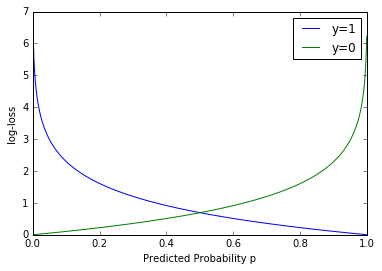

In [175]:
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline


def single_example_log_loss (y,p):
    return -(y*np.log(p)+(1-y)*np.log(1-p))



ps=np.arange(0.001,0.999,0.001)
log_loss_1=single_example_log_loss(1,ps) #the training example has true lable 1
log_loss_0=single_example_log_loss(0,ps) #the training example has true lable 0

plt.plot(ps, log_loss_1, label="y=1")
plt.xlabel('Predicted Probability p')
plt.ylabel('log-loss')
plt.plot(ps, log_loss_0, label="y=0")
plt.legend()
plt.show()

We seek to use the data we have available (labeled) to learn ("train") our function $f$ which belongs to some fixed class of possible functions $F$ through minimiziation of the expectation (i.e. the average) of the loss function which in practical terms means: $\underset{f\in F}{arg min}$ $L(f(X_{i}),y)$

See the following for a LOT of details skipped:

https://en.wikipedia.org/wiki/Empirical_risk_minimization

http://statweb.stanford.edu/~tibs/ElemStatLearn/





We want to fit our training data well.....but not too well............

<img src="meetup_files/statistical-classification-a-review-on-some-techniques-24-728.jpg"/>

The majority of supervised learning fall into either


<ul style="list-style-type:disc">
  <li>Regression - predicting a real valued scalar value</li>
  <li>Classification - predicting a lable</li>
  <ul style="list-style-type:disc">
      <li>Binary lables (e.g. "yes" or "no")</li>
      <li>Multually exclusive and exhuastive lables (e.g. "visit but not buy" or "visit and buy" or "not vist" )</li>
  </ul>
  </ul>
 
But there are other varieties which may include predicting...  
 <ul style="list-style-type:disc"> 
  <li>A sequence (e.g. next word in a sentence)</li>
  <li>A ranking (e.g. ranked list of recommendations) </li>
  <li>Ordinal variable (e.g. "Bad" or "Good" or "Great") </li>
  <li>Multi-lable variable (e.g. multiple outputs - non mutually exclusive) </li>
  <li>etc. </li>
</ul>



<h2>Toy Data For Example</h2>

For our example we will assume a vanilla binary classification model using a public dataset from UCI:

http://archive.ics.uci.edu/ml/datasets/Bank+Marketing


<img src="meetup_files/Selection_001.png"/>


In [150]:
import pandas as pd
from IPython.display import Image, display, HTML

#read in dataset
data_set = pd.read_csv('/home/jma/Desktop/Meetup/bank-full.csv',sep=';', header=0)

print "The shape of the data set (rows,columns): %s \n" % (str(data_set.shape))


#seperate out the label (y) from the predictors
X=data_set.iloc[:,0:data_set.shape[1]-1]
y=data_set.iloc[:,-1]

#print first 5 rows of y and X
print "Sample of y:\n" 
display(pd.DataFrame(y).head())
print "\nSample of X:\n" 
display(X.head())


The shape of the data set (rows,columns): (45211, 17) 

Sample of y:



,y
0,no
1,no
2,no
3,no
4,no



Sample of X:



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown


Machine learning algorithms typically require strings to be encoded numerically. For many algorithms strings need to be one-hot-encoded (i.e. 0/1 dummy codes for all levels - or one less for some linear models). 

Example: If marital takes on values in the set {'married','single', 'divorced'} a one-hot-encoding would be $[1,0,0]$ where the first position equals 1 when an example has a value of 'divorced' and the other 2 positions are 0. 'Married' would be $[0,1,0]$ etc. This results in 3 additional variables taking the place of the nominal variable martial. 

In the case of decision trees, it is often fine to map each string value to an integer index...




In [151]:
cat_cols=['job','marital','education','default','housing', 'loan','month','poutcome', 'contact']
cat_data_set = data_set[cat_cols]
display(cat_data_set.head())

,job,marital,education,default,housing,loan,month,poutcome,contact
0,management,married,tertiary,no,yes,no,may,unknown,unknown
1,technician,single,secondary,no,yes,no,may,unknown,unknown
2,entrepreneur,married,secondary,no,yes,yes,may,unknown,unknown
3,blue-collar,married,unknown,no,yes,no,may,unknown,unknown
4,unknown,single,unknown,no,no,no,may,unknown,unknown


In [152]:
#map each distinct value of the nominal variables to an integer

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
cat_data_set_indx=cat_data_set.apply(lambda x: le.fit_transform(x)+1,axis=1)

In [183]:
cat_data_set_indx.head()


,job,marital,education,default,housing,loan,month,poutcome,contact
0,1,2,5,4,7,4,3,6,6
1,5,4,3,2,7,2,1,6,6
2,1,2,5,4,7,7,3,6,6
3,1,2,5,4,6,4,3,5,5
4,4,3,4,2,2,2,1,4,4


In [154]:
#concatenate index values back to the numeric data of X
X=pd.concat([cat_data_set_indx,X.drop(cat_cols,axis=1)],axis=1)

print "The shape of X (rows,columns): %s \n" % (str(X.shape))

display(X.head())

print "\nThe datatypes of X:\n\n %s" %(X.dtypes)

The shape of X (rows,columns): (45211, 16) 



,job,marital,education,default,housing,loan,month,poutcome,contact,age,balance,day,duration,campaign,pdays,previous
0,1,2,5,4,7,4,3,6,6,58,2143,5,261,1,-1,0
1,5,4,3,2,7,2,1,6,6,44,29,5,151,1,-1,0
2,1,2,5,4,7,7,3,6,6,33,2,5,76,1,-1,0
3,1,2,5,4,6,4,3,5,5,47,1506,5,92,1,-1,0
4,4,3,4,2,2,2,1,4,4,33,1,5,198,1,-1,0



The datatypes of X:

 job          int64
marital      int64
education    int64
default      int64
housing      int64
loan         int64
month        int64
poutcome     int64
contact      int64
age          int64
balance      int64
day          int64
duration     int64
campaign     int64
pdays        int64
previous     int64
dtype: object


Xgboost requires MINIMAL preprocessing - missing values are fine as well), saving time and potential bias from imputation. There are none in this dataset....

In [155]:
X.apply(lambda x: x.isnull().values.any(), axis=0)

job          False
marital      False
education    False
default      False
housing      False
loan         False
month        False
poutcome     False
contact      False
age          False
balance      False
day          False
duration     False
campaign     False
pdays        False
previous     False
dtype: bool

In [156]:
#map y=yes to 1, otherwise 0
from __future__ import division

y= pd.Series([1 if x == 'yes' else 0 for x in y])
display(pd.DataFrame(y).head())

print 'Proportion of yes in the data set:\n %f' % (y.sum() / y.shape[0])

,0
0,0
1,0
2,0
3,0
4,0


Proportion of yes in the data set:
 0.116985


In [157]:
#split the data into training and testing - the test set will only be 
#used at the very last to estimate how well the model generalizes to unseen data
#we dont want to overfit like the picture above
#can use a another sample ('validation') to tune the model or use cross-validation which we will use here

from sklearn.model_selection import train_test_split

X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.3)

print "X_train shape", X_train.shape
print "y_train shape", y_train.shape
print "X_test shape", X_test.shape
print "y_test shape", y_test.shape


X_train shape (31647, 16)
y_train shape (31647,)
X_test shape (13564, 16)
y_test shape (13564,)


<h2>XGBoost</h2>

https://github.com/dmlc/xgboost

"Scalable, Portable and Distributed Gradient Boosting (GBDT, GBRT or GBM) Library, for Python, R, Java, Scala, C++ and more. Runs on single machine, Hadoop, Spark, Flink and DataFlow"


<ul style="list-style-type:disc">
  <li>Written in C++ by a PhD student at the University of Washington Tianqi Chen</li>
  <li>Extremely fast and accurate gradient boosting library (boosting for regression trees and generalized linear model)</li>
  <li>Is a part of nearly every winning model on Kaggle - especially blended with a neural network.</li>
  </ul>
  
  
If you are doing regression or classification that is not (e.g. image recognition) where deep learning is state of the art, xgboost is clearly the best off the shelf model today

We will focus on the decision tree boosting algorithm....

First, why are gradient boosting regression trees so awesome?

<ul style="list-style-type:disc">
  <li>Very accurate and robust</li>
  <li>Deals with missing values seamlessly - no need to impute </li>
  <li>Finds and incorporates non-linearity and interactions between variables automatically</li>
  <li>-----Feature creation (creating variables for the model) is still extremely important but by and large, gradient boosted regression trees are forgiving for throwing a lot of raw correlated data at it and getting a sensible (read: not optimal but still good) model returned</li>
  </ul>
  
  
Gradient boosting has been around for a long time (Jerome Friedman 1999 paper; R's GBM was state-of-the-art for many years). XGBoost improved the general algorithm, making it better and faster

Many images here stolen from Tianqi's presentation: http://homes.cs.washington.edu/~tqchen/data/pdf/BoostedTree.pdf


<h2>What is a decision tree ensemble?</h2>

<img src="meetup_files/Selection_002.png"/>


This is an additive model.....

<img src="meetup_files/Selection_004.png"/>

$f_{t}(x_{i})$ is the predicted value ('weight') at the leaf node that the $i^{th}$ training example falls into for iteration t. E.g. the "boy" receives '2' from the first tree (so t=1) 

The model is a sum of each decision tree prediction....

At each iteration, xgboost uses an objective function (like log-loss) to decide what decision tree should be added to the model already constructed from the prior iterations...it also accounts for how complex the model is - remember not to overfit!

<img src="meetup_files/Selection_003.png"/>


The complexity of the tree is a penalty against the objective function. We are looking to get the predicted value $\hat{y}$ as close to the true $y$ as possible.....but not too close - recall overfitting above. So, we penalize (increase) the objective function we are seeking to minimize for complex trees (consider an extremely complex tree where each node contains only 1 observation....perfectly predicting that example but meaningless for generalization)

Minimizing a loss function like this allows us to plug in various choices and instantly we are creating a model to predict a different target variable

<ul style="list-style-type:disc">
  <li>Squared error: a scalar real value</li>
  <li>Log-loss: a binary label </li>
  <li>Softmax: multinomial labels (> 2 lables) </li>
  <li>Poisson: counts / integers </li>
  <li>Pair-wise: ranking problems </li>
  <li>Your own (example later) </li>
  
  </ul>



<h2>XGBoost Use of Gradient And Hessian</h2>

<h4>TL;DR</h4> 

Along with complexity measures, the gradient (g) and hessian (h) (first and second derivative) of the loss function completely defines the objective. Xgboost approximates the loss function with a taylor expansion, gaining engineering benefits and speed-up.....g and h completely determine how best to create a decision tree (e.g. what predictors to split on and how) as well as the score value to give to each leaf node.

<b>-----------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------</b>

<b>-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------</b>


Start with the generic objective function:

<img src="meetup_files/Selection_005.png"/>


During each iteration (i.e. run through the data set) another tree is built, which is added to our model. The goal at each iteration $t$ is to minimize the objective function which is taken over all $n$ examples- where the only thing we are in control of is $f_{t}(x_{i})$, the previous $f$ are already set and do not change

<img src="meetup_files/Selection_006.png"/>


This is a taylor expansion from calculus. Xgboost uses this method to approximate the loss function at iteration $t$. $g_{i}$ is the first derivative of the loss function evaluated at the value of the $i^{th}$ training example (where the derivative is w.r.t. the $t-1$ iteration prediction. 

$h_{i}$ is the second derivative.

<img src="meetup_files/Capture.JPG"/>

When the loss is 'squared error' the $g$ and $h$ are:

<img src="meetup_files/Selection_008.png"/>

The objective function taylor exapansion approximation in the specific case of squared error.....

<img src="meetup_files/Selection_011.png"/>

We can remove the t-1 model component because it is a constant


<img src="meetup_files/Selection_009.png"/>


Why go through the trouble of showing this? It is the basis for what xgboost does....

Look at the objective above with all the constants removed (they dont matter for minimizing the function) - it only depends on $g$ and $h$ assuming a fixed tree $f_{t}$


Further, $g$ and $h$ becomes the sole basis for a fast scoring system to evaluate 

<ul style="list-style-type:disc">
  <li>How to best construct the decision tree at iteration $t$ (i.e. to decide which of a set of splitting options and pruning steps are superior): a "gain" metric is developed using only $g$ and $h$</li>
  <li>The optimal weights (scores) to assign to each leaf node</li>
    
  </ul>


<img src="meetup_files/capture2.png"/>



This in a nutshell is what set xgboost apart from legacy GBM implementations. The paper and slides linked here will fill in the gaps for the curious.... 

http://homes.cs.washington.edu/~tqchen/data/pdf/BoostedTree.pdf

http://arxiv.org/abs/1603.02754

<b>-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------</b>

<b>-----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------</b>

Lastly, the complexity of the tree may include penalizing deep trees or leafs with large score values (the value predicted by a tree for every example that falls into that leaf)..these type of things work to regulate the model and keep it from being unduly influenced by any noise in the training set.

Note $\gamma$ and $\lambda$ which regulate how much impact the complexity measure has on the overall objective function. We will set them later....

<img src="meetup_files/Selection_014.png"/>

<h2>Back to xgboost in Python and our toy data set....</h2>

In Python there are two choices on how to run xgboost

<ul style="list-style-type:disc">
  <li>Python API</li>
  <li>Scikit Learn compatible wrapper</li>
</ul>

We will focus on the former. There is fantastic documentation here: http://xgboost.readthedocs.org/en/latest/index.html



In [158]:
import xgboost as xgb

#Xgboost works off of sparse datasets (only non-zeros are included). 
#If we have missing values we tell the function what value represents
dtrain=xgb.DMatrix(X_train,label=y_train)
dtest=xgb.DMatrix(X_test,label=y_test)


#there are many parameters to tune. Each controls how expressive the model can be
#bias / variance trade off


#here is a dictionary of SOME of the parameters set to their defaults

myParams={
'learning_rate' :0.3, #step size shrinkage used in update to prevents overfitting - 
                       #how much to scale the new function f_t we add to the model
                        # this is like eta in gradient descent (0,1]

#control model complexity     
'max_depth':6, #how deep can we grow each tree - how many levels deep [1,inf]
'min_child_weight':1, #minimum weight (leaf score) for a child node to be created [0,inf]
'gamma':0, # larger values penalize the number of trees grown (see complexity formula above) [0, inf]

#control robustness to noise
'subsample':0.8, #each iteration we sample this proportion of examples 
                 #so not all are included each iteration in the tree growing (0,1]
'colsample_bytree':0.8,#each iteration we sample this proportion of predictors (0,1]
    

'objective': 'binary:logistic', #our objective function (cross entropy)
'nthread':8, #number of threads to use
    

'seed':1234 #for reproducability
    }

#train our model (num_boost_round is number of iterations / trees to include)
model_1= xgb.train(params=myParams, dtrain=dtrain,num_boost_round=50)


<h2>Plotting Trees and Importance</h2>

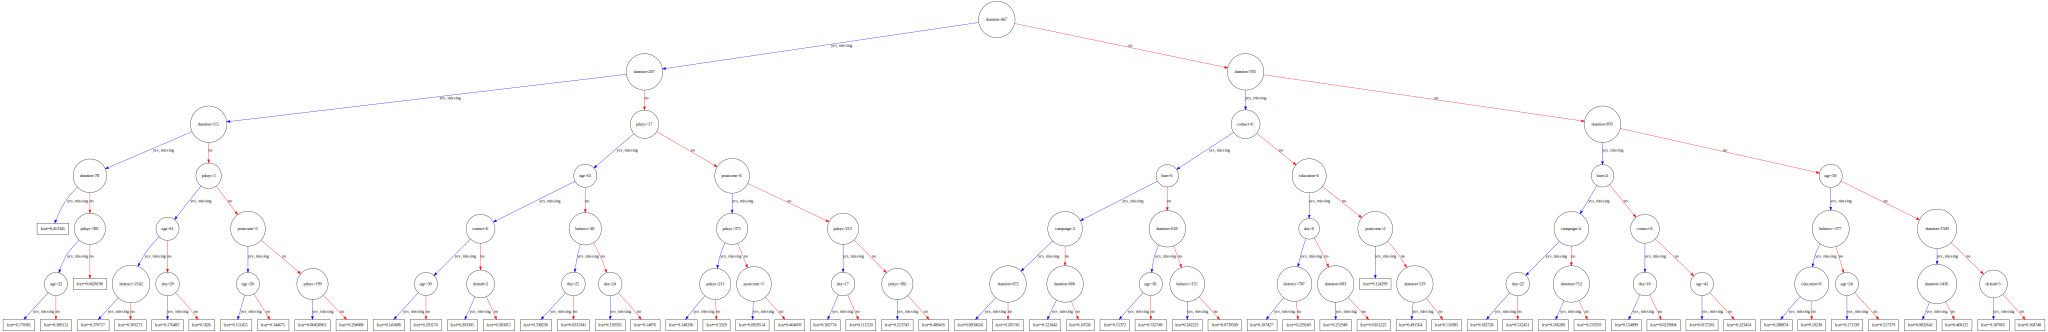

In [159]:
import graphviz

#visualize a specific tree (the leaf value is the weight or the log-odds in the case of binary logistic)
xgb.to_graphviz(model_1, num_trees=2)


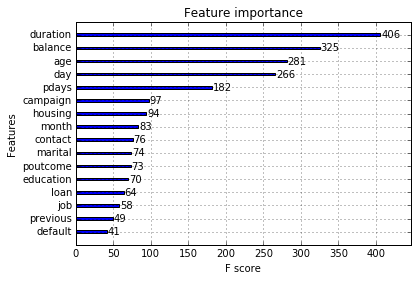

In [160]:
#relative importance of the predictors (fscore = number of times the predictor was split on)
from matplotlib import pylab as plt
%matplotlib inline
xgb.plot_importance(model_1)
plt.show()

In [176]:
"""
Partial plots not yet available :( (see GBM in sci-kit learn)
Would need to roll your own by sampling over the range of the variable(s) of 
interest and evaluating the model for each sampled value, averaging over the
given values of the other variables in the model 

http://adventuresindm.blogspot.com/2013/01/partial-dependency-plots-and-gbm.html

"""

<h2>Built-in Cross Validation</h2>

Xgboost has built in k-fold cross validation, saving the data scientist from having to code their own

The basic process is as follows:

<ul style="list-style-type:disc">
  <li>Divide the dataset into k parts (e.g. k=3)</li>
  <li>For each iteration... </li>
      <ul style="list-style-type:disc">
          
      <li>Train the model on all but the $i^{th}$ part (e.g. part 1 and 2) and predict the value of the $i^{th}$ part  </li>
      <li>Repeat so that each part is part of training and evaluation </li>
      <li>Compute the average evaluation metric (e.g. Area Under the Curve) and the standard deviation </li>
       
       
</ul>


In [179]:
model_2=xgb.cv(params=myParams, dtrain=dtrain,num_boost_round=500, nfold=3,as_pandas=True,metrics='auc' )
model_2.head()

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.859559,0.004133,0.872217,0.003728
1,0.880270,0.001482,0.896355,0.002249
2,0.889330,0.000385,0.906054,0.001925
3,0.894551,0.000795,0.912103,0.001037
4,0.897088,0.001079,0.915284,0.001148


AUC: The interpretation is that given a random positive observation and negative observation, the AUC gives the proportion of the time you guess which is correct. It is a common measure of how well a model ranks a binary label

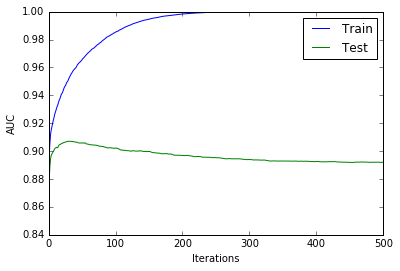

In [180]:
#lets plot the full 500 iterations
#clearly we are overfitting past around 25 iterations
plt.plot(model_2['train-auc-mean'])
plt.plot(model_2['test-auc-mean'])
plt.legend(['Train', 'Test'], loc='upper right')
plt.xlabel("Iterations")
plt.ylabel("AUC")
plt.show()

<h2>Early Stopping</h2>

Early stopping can be used with or without cv (without cv requies a seperate test set)
If the test-auc-mean doesnt improve for 'early_stopping_rounds' (aptly called 'patience' with neural networks) then terminate and return the model as of the best performing number of iterations

In [164]:
xgb.cv(params=myParams, dtrain=dtrain,num_boost_round=500, nfold=3,as_pandas=True,metrics='auc', 
       early_stopping_rounds=5)

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.859559,0.004133,0.872217,0.003728
1,0.880270,0.001482,0.896355,0.002249
2,0.889330,0.000385,0.906054,0.001925
3,0.894551,0.000795,0.912103,0.001037
4,0.897088,0.001079,0.915284,0.001148
5,0.897938,0.001447,0.917633,0.000665
6,0.898671,0.000932,0.919883,0.000423
7,0.899645,0.000733,0.921975,0.000584
8,0.900589,0.000638,0.923750,0.000636
9,0.901571,0.000164,0.926117,0.000289


<h2>Custom Objective, Preprocessing and Evaluation</h2>

Another great feature of xgboost is being able to write your own custom.... 

<ul style="list-style-type:disc">
  <li>Objective/loss function (what to optimize while building the model)</li>
  <li>Pre-processing (some data transformation at each iteration)</li>
  <li>Evaluation function (the metric you are interested in) </li>
</ul>

Lets look at a custom objective/loss function. Recall, all you need to do is be able to define a first and second order derivative for your loss...


We are using log-loss in our model already as it is defined by xgboost, but it can serve as an example.




In [165]:
import numpy as np

#grad = first derivative of log-loss
#grad = second derivative
#(note that log-odds and not probability is returned by xgboost, they call it the margin)
def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds))
    grad = preds - labels
    hess = preds * (1.0-preds)
    return grad, hess

In [166]:
xgb.cv(params=myParams, dtrain=dtrain,num_boost_round=500, nfold=3,as_pandas=True,metrics='auc', 
       early_stopping_rounds=5, obj=logregobj)

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.853020,0.002391,0.863723,0.003516
1,0.877492,0.000788,0.890781,0.000879
2,0.885831,0.003066,0.899772,0.004168
3,0.892247,0.001500,0.904957,0.001189
4,0.893171,0.001703,0.905788,0.001223
5,0.893970,0.002218,0.906714,0.001001
6,0.894133,0.002217,0.907379,0.000543
7,0.893977,0.002135,0.907572,0.000595
8,0.893933,0.001898,0.907163,0.000756
9,0.894210,0.001987,0.908038,0.001486


In [167]:
#maybe we care less about AUC (how well the model rank orders examples) and we really care about 
#how accurate the model would classify each example as yes or no 

def evalaccuracy(preds, dtrain):
    
    labels = dtrain.get_label() 
    
    #preds is log-odds from xgboost (called margin)
    #so, preds >0 is the same as probability > 0.5
       
    return 'accuracy', float(sum(labels != (preds > 0.0))) / len(labels)


In [168]:
xgb.cv(params=myParams, dtrain=dtrain,num_boost_round=10, nfold=3,as_pandas=True, 
       early_stopping_rounds=5, feval=evalaccuracy)

,test-accuracy-mean,test-accuracy-std,train-accuracy-mean,train-accuracy-std
0,0.882611,0.001514,0.882611,0.000757


<h2>Feature Engineering</h2>


This is the most important step in building predictive models. Often more important than parameter settings (assuming reasonable defaults) and even the type of model being used - regular old logistic regression versus state of the art xgboost or deep neural networks


Feature engineering refers to creating the right type of information for the model to learn from. In a real world application this requires domain knowledge. For example in banking, maybe a model is predicting who will be turned down for a home equity loan. We might have access to the estimated value of a persons home and how much their mortage is. We could feed these into the model and perhaps do ok, but the underwriting process is concerned with loan-to-value ratio so we should divide the outstanding loan amount by the value of the home. 

You need to help the model by giving it features to learn from....there is no magic in what they do. This means asking the right questions of experts in the business and seeking out and testing data

Even when we are given a data set and have no opportunity to understand the variables (Kaggle) it is still helpful to consider subtracting predictors, dividing them etc.






<h2>Parameter Tuning</h2>

Xgboost (and a lot of the more complex algorithms) have a lot of free parameters, whose values influences how well a model can learn the training data and how well they will generalize to new data. This is the bias versus variance tradeoff. If we build extremely deep trees, we will learn the training data too well and we will see results on new data, when values change from the training data that are quite different than we saw during development

Each parameter (we did not see all of them above) influence the model and we need to tune them. The parameters are not independent and the number of permutations explode and become intractable. We need a stratedgy. This is an open problem and we could spend hours just exploring a couple of methods. We will show one strategy for xgboost and one methodology that works pretty well in lots of cases

Full list of xgboost parameters: https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

<h3>Strategy for Xgboost</h3>

This strategy has been discussed in various places (e.g. Kaggle) and generally tends to work


<ul style="list-style-type:disc">
  <li>Start with a relatively high learning rate (allows the model to adjust quite a bit from each iteration) and find the optimal number of trees (iterations). Set all other parameters at defaults </li>
  <li>Given this learning rate and number of trees - tune other most important (empiricaly) parameters:  </li>
      <ul style="list-style-type:disc">
          
      <li>max_depth</li>
      <li>min_child_weight </li>
      <li>gamma</li>
      <li>subsample</li>
      <li>colsample_bytree</li>
      </ul> 
 <li>Given these parameter settings, tune regularization parameters (e.g. lambda which controls how much the norm of the weights affect the objective function - see $\lambda$ in image above)  </li>   
 <li>Finally, with these settings, reduce the learning rate and search for number of iterations (trees) again </li>  
</ul>

Step 1 we essentially did already with early stopping finding ~30 trees

We will show (a part of) step 2 using random search with scikit learn (note: there are several ways you will find to do this, we are combining some of xgboost native functions and scikit). Using scikit soley would allow for parraell procressing but we would need to use the scikit wrapper for xgboost. The intent here was to make the process more illustrative but we are making a large computation cost trade-off


In [169]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import ParameterSampler

np.random.seed(87655678)

#dictionary of parameters - some constants and some a distribution
#You can use any statistical distrbution you think makes sense, here we are
#only looking at random inetgers between (a,b)
#and a uniform between 0.5 and 0.9

param_dist = {'learning_rate' :[0.3],
              "'max_depth'": sp_randint(2, 9),
              "min_child_weight": sp_randint(1, 5),
              "gamma": sp_randint(0, 3),
              "subsample": sp_uniform(loc=0.5,scale=0.4), #uniform (loc, loc+scale)
              "colsample_bytree": [0.8],
              "objective": ['binary:logistic'],
              "nthread": [8],
              "seed": [1234]
             }
param_dist

{"'max_depth'": <scipy.stats._distn_infrastructure.rv_frozen at 0x7f4a98da0b10>,
 'colsample_bytree': [0.8],
 'gamma': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f4a98da0e90>,
 'learning_rate': [0.3],
 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f4a98da0c50>,
 'nthread': [8],
 'objective': ['binary:logistic'],
 'seed': [1234],
 'subsample': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f4a98d78090>}

In [170]:
param_list = list(ParameterSampler(param_dist, n_iter=3))
param_list

[{"'max_depth'": 2,
  'colsample_bytree': 0.8,
  'gamma': 2,
  'learning_rate': 0.3,
  'min_child_weight': 2,
  'nthread': 8,
  'objective': 'binary:logistic',
  'seed': 1234,
  'subsample': 0.7379449755408413},
 {"'max_depth'": 7,
  'colsample_bytree': 0.8,
  'gamma': 0,
  'learning_rate': 0.3,
  'min_child_weight': 1,
  'nthread': 8,
  'objective': 'binary:logistic',
  'seed': 1234,
  'subsample': 0.8620477093552172},
 {"'max_depth'": 6,
  'colsample_bytree': 0.8,
  'gamma': 1,
  'learning_rate': 0.3,
  'min_child_weight': 4,
  'nthread': 8,
  'objective': 'binary:logistic',
  'seed': 1234,
  'subsample': 0.786538597067273}]

In [181]:
#loop through our created parameter dictionaries

iterations=33
hold_xval_auc=[]

for i in range(len(param_list)):
    result=xgb.cv(params=param_list[i], dtrain=dtrain, num_boost_round=iterations, nfold=3, 
                  metrics='auc',as_pandas=True )
    hold_xval_auc.append(result['test-auc-mean'][iterations-1])
    
print 'Best AUC: ', hold_xval_auc[np.argmax(hold_xval_auc)] 
print 'Best Parameters: ', param_list[np.argmax(hold_xval_auc)]
best_params=param_list[np.argmax(hold_xval_auc)]

Best AUC:  0.907129666667
Best Parameters:  {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'nthread': 8, 'min_child_weight': 2, 'subsample': 0.7379449755408413, 'seed': 1234, "'max_depth'": 2, 'objective': 'binary:logistic', 'gamma': 2}


If this were a real application (and we ran a lot more than 3 draws from the parameter distributions) we would probaly want to do this again, with narrower ranges for the parameters to help "zero-in" on the best values. E.g. If we found that best performance had col_sample= 0.795 and the next closest was 9.10, maybe we would want to test between these two.

We could then use these settings and decrease the learning rate to 0.01 (maybe) and find optimal number of trees

In [182]:
best_params['learning_rate']=0.01
print best_params

xgb.cv(params=best_params, dtrain=dtrain,num_boost_round=5000, nfold=3,as_pandas=True,metrics='auc', 
       early_stopping_rounds=5)

{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'nthread': 8, 'min_child_weight': 2, 'subsample': 0.7379449755408413, 'seed': 1234, "'max_depth'": 2, 'objective': 'binary:logistic', 'gamma': 2}


,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.854491,0.004144,0.866666,0.002643
1,0.878574,0.001595,0.891269,0.002372
2,0.884727,0.000702,0.899790,0.004055
3,0.889374,0.002321,0.903801,0.000905
4,0.890979,0.001037,0.904876,0.001091
5,0.891803,0.001049,0.905567,0.001231
6,0.892050,0.002008,0.906151,0.000717
7,0.891922,0.002096,0.906224,0.000441
8,0.891839,0.002148,0.905791,0.000523
9,0.892407,0.002198,0.906485,0.001607


There are many ways to tune parameters. Hyperopt is a really nice way to find optimal points but does have a bit of a learning curve - especially to run in parallel 

https://github.com/hyperopt/hyperopt

<h2>Prediction, Model Saving</h2>

In [173]:
#then train the model on the full training set using the parameters

model_2= xgb.train(params=best_params, dtrain=dtrain,num_boost_round=756)

#save model
model_2.save_model('/home/jma/Desktop/Meetup/xgboostmodel_002.mod')
#dump text representation of the trees
model_2.dump_model('/home/jma/Desktop/Meetup/xgboostmodel_002.dump')

#score the test set
preds=model_2.predict(dtest)

#how well did we do?
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,preds)

0.91538469690434543

<b>Other things in the API:</b>

<ul style="list-style-type:disc">
  <li>Update models that have been saved with new data</li>
  <li>External memory training - incrementally train model reading large data from disk</li>
  <li>Predict not the outcome but the leaf node index of a given example - useful as input into other models such as linear regression where the node IDs are one-hot-encoded</li>
    <li>Learning rate schedules - change learning rates while training (e.g. exponential decay to learn fast at the beginning and then slower and refined) </li>
 </ul>

